# Reqd funcitons


In [1]:
import torch
import numpy as np
import torch
from numpy.linalg import solve, svd, norm
import matplotlib
import matplotlib.pyplot as plt
# import classic_kernel

import time
from tqdm import tqdm
# import hickle

# For DT data
from data import return_data_elements
from types import SimpleNamespace

In [2]:
'''Implementation of kernel functions.'''

def euclidean_distances(samples, centers, squared=True):
    '''Compute the Euclidean distances between samples and centers.
    
    Args: 
        samples: of shape (n_sample, n_feature).
        centers: of shape (n_center, n_feature).
        squared: whether to return squared distances.
        
    Returns:
        distances: of shape (n_sample, n_center).
    
    '''
    samples_norm = torch.sum(samples**2, dim=1, keepdim=True)
    if samples is centers:
        centers_norm = samples_norm
    else:
        centers_norm = torch.sum(centers**2, dim=1, keepdim=True)
    centers_norm = torch.reshape(centers_norm, (1, -1))

    distances = samples.mm(torch.t(centers))
    distances.mul_(-2)
    distances.add_(samples_norm)
    distances.add_(centers_norm)
    #print(centers_norm.size(), samples_norm.size(), distances.size())
    if not squared:
        distances.clamp_(min=0)
        distances.sqrt_()

    return distances


def euclidean_distances_M(samples, centers, M, squared=True):
    '''Compute the Euclidean distances between samples and centers.

    Args:
        samples: of shape (n_sample, n_feature).
        centers: of shape (n_center, n_feature).
        squared: whether to return squared distances.
    
    Returns:
        distances: of shape (n_sample, n_center).
    '''

    samples_norm = (samples @ M)  * samples
    samples_norm = torch.sum(samples_norm, dim=1, keepdim=True)

    if samples is centers:
        centers_norm = samples_norm
    else:
        centers_norm = (centers @ M) * centers
        centers_norm = torch.sum(centers_norm, dim=1, keepdim=True)

    centers_norm = torch.reshape(centers_norm, (1, -1))

    distances = samples.mm(M @ torch.t(centers))
    distances.mul_(-2)
    distances.add_(samples_norm)
    distances.add_(centers_norm)

    if not squared:
        distances.clamp_(min=0)
        distances.sqrt_()

    return distances


def gaussian(samples, centers, bandwidth):
    '''Gaussian kernel.

    Args:
        samples: of shape (n_sample, n_feature).
        centers: of shape (n_center, n_feature).
        bandwidth: kernel bandwidth.

    Returns:
        kernel matrix of shape (n_sample, n_center).
    '''
    assert bandwidth > 0
    kernel_mat = euclidean_distances(samples, centers)
    kernel_mat.clamp_(min=0)
    gamma = 1. / (2 * bandwidth ** 2)
    kernel_mat.mul_(-gamma)
    kernel_mat.exp_()

    #print(samples.size(), centers.size(),
    #      kernel_mat.size())
    return kernel_mat


def laplacian(samples, centers, bandwidth):
    '''Laplacian kernel.

    Args:
        samples: of shape (n_sample, n_feature).
        centers: of shape (n_center, n_feature).
        bandwidth: kernel bandwidth.

    Returns:
        kernel matrix of shape (n_sample, n_center).
    '''
    assert bandwidth > 0
    kernel_mat = euclidean_distances(samples, centers, squared=False)
    kernel_mat.clamp_(min=0)
    gamma = 1. / bandwidth
    kernel_mat.mul_(-gamma)
    kernel_mat.exp_()
    return kernel_mat



def laplacian_M(samples, centers, bandwidth, M):
    assert bandwidth > 0
    kernel_mat = euclidean_distances_M(samples, centers, M, squared=False)
    kernel_mat.clamp_(min=0)
    gamma = 1. / bandwidth
    kernel_mat.mul_(-gamma)
    kernel_mat.exp_()
    return kernel_mat


def dispersal(samples, centers, bandwidth, gamma):
    '''Dispersal kernel.

    Args:
        samples: of shape (n_sample, n_feature).
        centers: of shape (n_center, n_feature).
        bandwidth: kernel bandwidth.
        gamma: dispersal factor.

    Returns:
        kernel matrix of shape (n_sample, n_center).
    '''
    assert bandwidth > 0
    kernel_mat = euclidean_distances(samples, centers)
    kernel_mat.pow_(gamma / 2.)
    kernel_mat.mul_(-1. / bandwidth)
    kernel_mat.exp_()
    return kernel_mat


In [7]:
def get_mse(y_pred, y_true):
    return np.mean(np.square(y_pred - y_true))


def kernel(pair1, pair2, nngp=False):
    
    out = pair1 @ pair2.transpose(1, 0)
    N1 = torch.sum(torch.pow(pair1, 2), dim=-1).view(-1, 1)
    N2 = torch.sum(torch.pow(pair2, 2), dim=-1).view(-1, 1)

    XX = torch.sqrt(N1 @ N2.transpose(1, 0))
    out = out / XX

    out = torch.clamp(out, -1, 1)

    first = 1/np.pi * (out * (np.pi - torch.acos(out)) \
                       + torch.sqrt(1. - torch.pow(out, 2))) * XX
    if nngp:
        out = first
    else:
        sec = 1/np.pi * out * (np.pi - torch.acos(out)) * XX
        out = first + sec

    return out

def laplace_kernel(pair1, pair2, bandwidth):
    return laplacian(pair1, pair2, bandwidth)

def laplace_kernel_M(pair1, pair2, bandwidth, M):
    return laplacian_M(pair1, pair2, bandwidth, M)


def original_ntk(X_train, y_train, X_test, y_test, use_nngp=False):
    K_train = kernel(X_train, X_train, nngp=use_nngp).numpy()
    sol = solve(K_train, y_train).T
    K_test = kernel(X_train, X_test, nngp=use_nngp).numpy()
    y_pred = (sol @ K_test).T

    mse = get_mse(y_pred, y_test.numpy())
    if use_nngp:
        print("Original NNGP MSE: ", mse)
        return mse
    else:
        print("Original NTK MSE: ", mse)
        return mse


def get_grads(X, sol, L, P):
    M = 0.

    start = time.time()
    num_samples = 20000   # what is this?
    indices = np.random.randint(len(X), size=num_samples)

    #"""
    if len(X) > len(indices):
        x = X[indices, :]
    else:
        x = X

    #n, d = X.shape
    #x = np.random.normal(size=(1000, d))
    #x = torch.from_numpy(x)

    K = laplace_kernel_M(X, x, L, P)

    dist = euclidean_distances_M(X, x, P, squared=False)
    dist = torch.where(dist < 1e-10, torch.zeros(1).float(), dist)

    K = K/dist
    K[K == float("Inf")] = 0.

    a1 = torch.from_numpy(sol.T).float()
    n, d = X.shape
    n, c = a1.shape
    m, d = x.shape

    a1 = a1.reshape(n, c, 1)
    X1 = (X @ P).reshape(n, 1, d)
    step1 = a1 @ X1
    del a1, X1
    step1 = step1.reshape(-1, c*d)

    step2 = K.T @ step1
    del step1

    step2 = step2.reshape(-1, c, d)

    a2 = torch.from_numpy(sol).float()
    step3 = (a2 @ K).T

    del K, a2

    step3 = step3.reshape(m, c, 1)
    x1 = (x @ P).reshape(m, 1, d)
    step3 = step3 @ x1

    G = (step2 - step3) * -1/L

    M = 0.

    bs = 10
    batches = torch.split(G, bs)
    #for i in tqdm(range(len(batches))):
    for i in range(len(batches)):
        grad = batches[i].cuda()
        gradT = torch.transpose(grad, 1, 2)
        #gradT = torch.swapaxes(grad, 1, 2)#.cuda()
        M += torch.sum(gradT @ grad, dim=0).cpu()
        del grad, gradT
    torch.cuda.empty_cache()
    M /= len(G)

    M = M.numpy()

    end = time.time()

    #print("Time: ", end - start)
    return M


def convert_one_hot(y, c):
    o = np.zeros((y.size, c))
    o[np.arange(y.size), y] = 1
    return o


def hyperparam_train(X_train, y_train, X_test, y_test, c,
                     iters=5, reg=0, L=10, normalize=False):

    y_t_orig = y_train
    y_v_orig = y_test
    y_train = convert_one_hot(y_train, c)
    y_test = convert_one_hot( y_test, c)

    if normalize:
        X_train /= norm(X_train, axis=-1).reshape(-1, 1)
        X_test /= norm(X_test, axis=-1).reshape(-1, 1)

    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()

    best_acc = 0.
    best_iter = 0.
    best_M = 0.
    test_acc_list = []
    M_list = []

    n, d = X_train.shape
    M = np.eye(d, dtype='float32')

    for i in range(iters):
        print('a')
        K_train = laplace_kernel_M(X_train, X_train, L, torch.from_numpy(M)).numpy()
        sol = solve(K_train + reg * np.eye(len(K_train)), y_train).T

        K_test = laplace_kernel_M(X_train, X_test, L, torch.from_numpy(M)).numpy()
        preds = (sol @ K_test).T

        y_pred = torch.from_numpy(preds)
        preds = torch.argmax(y_pred, dim=-1)
        labels = torch.argmax(y_test, dim=-1)
        count = torch.sum(labels == preds).numpy()

        old_test_acc = count / len(labels)
        print(old_test_acc)
        test_acc_list.append(old_test_acc)
        if old_test_acc > best_acc:
            best_iter = i
            best_acc = old_test_acc
            best_M = M
        M  = get_grads(X_train, sol, L, torch.from_numpy(M))
        M_list.append(M)
        print(M)

    return best_acc, best_iter, best_M, test_acc_list, M_list


def train(X_train, y_train, X_test, y_test, c, M,
          iters=5, reg=0, L=10, normalize=False):

    y_t_orig = y_train
    y_v_orig = y_test
    y_train = convert_one_hot(y_train, c)
    y_test = convert_one_hot(y_test, c)

    if normalize:
        X_train /= norm(X_train, axis=-1).reshape(-1, 1)
        X_test /= norm(X_test, axis=-1).reshape(-1, 1)

    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()

    K_train = laplace_kernel_M(X_train, X_train, L, torch.from_numpy(M)).numpy()
    sol = solve(K_train + reg * np.eye(len(K_train)), y_train).T

    K_test = laplace_kernel_M(X_train, X_test, L, torch.from_numpy(M)).numpy()
    preds = (sol @ K_test).T

    y_pred = torch.from_numpy(preds)
    preds = torch.argmax(y_pred, dim=-1)
    labels = torch.argmax(y_test, dim=-1)
    count = torch.sum(labels == preds).numpy()

    acc = count / len(labels)
    return acc


## DT data

In [41]:
data_config1 = SimpleNamespace(
    dim_in=100,
    depth=4,
    num_points=10000,
    type_data='spherical',
    radius=1
)

In [12]:
data_config2 = SimpleNamespace(
    dim_in=10,
    depth=3,
    num_points=30000,
    type_data='spherical',
    radius=1
)

In [42]:
data = return_data_elements(data_config1)
X_train, y_train, X_test, y_test = data
# convert to numpy
X_train = X_train.numpy()
y_train = y_train.numpy().astype(int)
X_test = X_test.numpy()
y_test = y_test.numpy().astype(int)

In [43]:
best_acc, best_iter, best_M, test_acc_list, M_list = hyperparam_train(X_train, y_train, X_test, y_test, 2,
          iters=10, reg=0.1, L=10, normalize=False)

a
0.6379
[[ 0.08643673 -0.00083264  0.00911692 ... -0.00465741  0.00157307
   0.00383812]
 [-0.00083264  0.04802069 -0.00239547 ...  0.00357478 -0.0007644
   0.00551812]
 [ 0.00911692 -0.00239547  0.06938221 ... -0.00806893  0.00547164
  -0.0090844 ]
 ...
 [-0.00465741  0.00357478 -0.00806893 ...  0.01672128 -0.00119519
  -0.00018844]
 [ 0.00157307 -0.0007644   0.00547164 ... -0.00119519  0.01294487
  -0.00113221]
 [ 0.00383812  0.00551812 -0.0090844  ... -0.00018844 -0.00113221
   0.01781033]]
a
0.6491
[[ 3.1453556e-01 -4.7793183e-03  3.0017359e-02 ... -1.3772147e-02
   2.5897657e-03  2.8170651e-02]
 [-4.7793183e-03  5.5115666e-02  1.8007684e-03 ...  6.6889687e-03
   4.0669739e-03  8.0143642e-03]
 [ 3.0017359e-02  1.8007684e-03  9.9839002e-02 ... -9.5542362e-03
   5.0565363e-03 -9.7925467e-03]
 ...
 [-1.3772147e-02  6.6889687e-03 -9.5542362e-03 ...  9.4355550e-03
   1.1687825e-03  2.5029744e-03]
 [ 2.5897657e-03  4.0669739e-03  5.0565363e-03 ...  1.1687825e-03
   5.4527242e-03 -9.6987

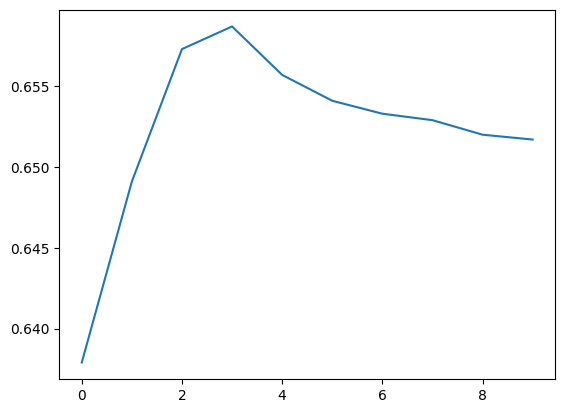

In [44]:
plt.plot(test_acc_list)

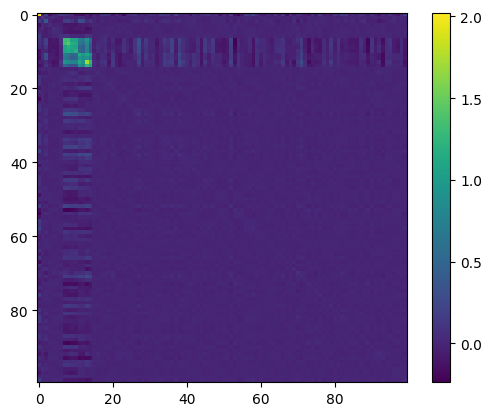

In [50]:
# plot heatmap of M
plt.figure()
plt.imshow(best_M)
plt.colorbar()
# plt.savefig('M.png')

In [11]:
best_M

array([[ 2.2251146e+00,  1.7302230e-02,  2.8955841e-02, -2.3737261e-02,
         1.1092315e-02, -2.0200150e-02, -3.4921765e-02,  5.9065685e-02,
         3.1498358e-02,  2.1191347e-02],
       [ 1.7302230e-02,  6.6986883e-01,  1.2438996e-02, -1.8239196e-02,
         9.8276222e-03, -1.9925293e-03, -1.2310948e-02, -2.5994026e-03,
        -1.0369842e-02, -9.6620554e-03],
       [ 2.8955841e-02,  1.2438996e-02,  5.9446639e-01,  1.3285185e-02,
         9.1652498e-03, -4.6650339e-02, -2.3067655e-02, -2.1765397e-03,
        -4.0423926e-03, -3.8623954e-03],
       [-2.3737261e-02, -1.8239196e-02,  1.3285185e-02,  9.8756921e-01,
         8.7612018e-02,  2.1285325e-02,  4.5341276e-02,  6.2768697e-04,
         2.8698551e-02, -1.1552572e-03],
       [ 1.1092315e-02,  9.8276222e-03,  9.1652498e-03,  8.7612018e-02,
         9.0265608e-01,  9.0594636e-03,  3.5480294e-02,  5.3148451e-03,
        -9.6589085e-03, -3.9378792e-02],
       [-2.0200150e-02, -1.9925293e-03, -4.6650339e-02,  2.1285325e-02,
   